In [3]:
from collections import deque
import csv

graph = {}

with open('World.csv', 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    next(csv_reader) #remove header
    for row in csv_reader:
        if row[0] not in graph:
            graph[row[0]] = set()
        graph[row[0]].add(row[1])


{'Papua New Guinea': {'Indonesia', 'Australia', 'Japan', 'Micronesia', 'China', 'Hong Kong', 'Solomon Islands', 'Philippines', 'Fiji', 'Singapore'}, 'Greenland': {'Denmark', 'Iceland'}, 'Iceland': {'Norway', 'Czech Republic', 'Netherlands', 'Faroe Islands', 'Belgium', 'United States', 'Sweden', 'France', 'Spain', 'Hungary', 'Finland', 'Austria', 'Switzerland', 'Denmark', 'Germany', 'Lithuania', 'Ireland', 'Poland', 'United Kingdom', 'Latvia', 'Canada'}, 'Canada': {'Morocco', 'Netherlands Antilles', 'Cayman Islands', 'Cuba', 'Jordan', 'Costa Rica', 'Ukraine', 'Saint Kitts and Nevis', 'Hong Kong', 'Puerto Rico', 'Aruba', 'Netherlands', 'China', 'El Salvador', 'Peru', 'Belgium', 'Haiti', 'Qatar', 'Guyana', 'United States', 'Japan', 'Italy', 'Egypt', 'France', 'Spain', 'United Arab Emirates', 'Saint Pierre and Miquelon', 'Hungary', 'Austria', 'Brazil', 'Switzerland', 'Saudi Arabia', 'Turkey', 'New Zealand', 'Jamaica', 'Taiwan', 'Martinique', 'Colombia', 'Australia', 'India', 'Russia', 'Mex

In [13]:
def graph_diameter(graph):
    max_diameter = 0
    for node in graph:
        distances = bfs(graph, node)
        max_distance = max(distances.values())
        max_diameter = max(max_diameter, max_distance)
    return max_diameter


def bfs(graph, start):
    visited = set()
    queue = deque([(start, 0)])
    distances = {start: 0}

    while queue:
        node, dist = queue.popleft()

        if node not in visited:
            visited.add(node)
            for neighbor in graph.get(node, []):
                if neighbor not in distances:
                    distances[neighbor] = dist + 1
                    queue.append((neighbor, dist + 1))

    return distances

print(f'Network diameter: {graph_diameter(graph)}')

Network diameter: 7


In [14]:
import networkx as nx

nx_graph = nx.DiGraph()

for node, neighbors in graph.items():
    nx_graph.add_node(node)
    for neighbor in neighbors:
        nx_graph.add_edge(node, neighbor)

In [17]:
import math

average_degree = sum(dict(nx_graph.degree()).values()) / len(nx_graph)
print(f'Average degree: {math.ceil(average_degree)}')

Average degree: 25


In [20]:
clustering_coefficient = nx.average_clustering(G)
print(f'Clustering coefficient: {round(clustering_coefficient, 2)}')

Clustering coefficient: 0.33


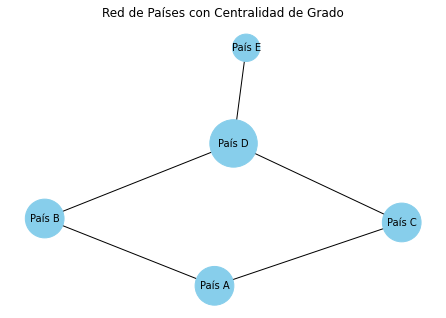

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo de ejemplo (sustituye esto con tus datos)
G = nx.Graph()
G.add_nodes_from(['País A', 'País B', 'País C', 'País D', 'País E'])
G.add_edges_from([('País A', 'País B'), ('País A', 'País C'), ('País B', 'País D'), ('País C', 'País D'), ('País D', 'País E')])

# Calcular la centralidad de grado de cada nodo
degree_centrality = nx.degree_centrality(G)

# Asignar el tamaño de los nodos según la centralidad de grado
node_sizes = [3000 * degree_centrality[node] for node in G.nodes]

# Crear la representación gráfica
pos = nx.spring_layout(G)  # Posicionamiento de los nodos
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10)
plt.title('Red de Países con Centralidad de Grado')
plt.show()

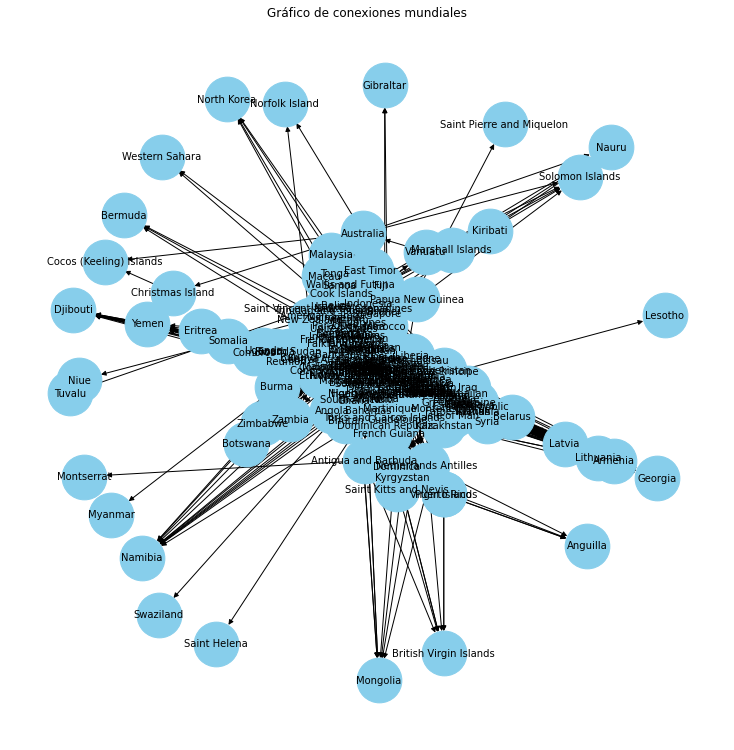

In [6]:
from collections import deque
import csv
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo dirigido
G = nx.DiGraph()

with open('World.csv', 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    next(csv_reader)  # Remover la cabecera
    for row in csv_reader:
        source, target = row[0], row[1]
        G.add_edge(source, target)

# Dibujar el gráfico directamente en Jupyter Notebook
pos = nx.spring_layout(G)  # Distribución de los nodos
plt.figure(figsize=(10, 10))  # Tamaño del gráfico
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10)
plt.title("Gráfico de conexiones mundiales")
plt.axis('off')  # Ocultar ejes
plt.show()